In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import utils
import torch

from einops import rearrange, reduce, repeat

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler, scale
from scipy.spatial import distance
import scipy.signal


In [322]:
def plot_clusters(x, y, labels, ax=None, colormap='Set1', seqColormap='rainbow', plot_line=True, ):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if plot_line:
        ax.plot(x, y, 'k', alpha=0.1)        
    if seqColormap is not None:
        ax.scatter(x, y, c=labels, s=20, cmap=seqColormap, alpha=1)
        
    cmap = mpl.cm.get_cmap(colormap)
    edgecolors = cmap(range(len(x)))
    ax.scatter(x, y, s=80, edgecolors=edgecolors,
               linewidths=2, facecolors='none', alpha=0.5)
    ax.axis('equal')
    if ax is None:
        return fig, ax
    

def traj_withWeight(x, y, w, align='e', ax=None):
    ''' Plot trajectory with weights
    align: 'e'(default) end, 's' start, 'c' center
    '''
    from sklearn.preprocessing import minmax_scale
    n = len(x)
    nW = len(w)
    if align == 's':
        offset = 0
    elif align == 'e':
        offset = n - nW
    elif align == 'c':
        offset = (n - nW)//2
    else:
        raise ValueError('align must be e, s, or c')
    w = minmax_scale(w, feature_range=(0, 100)) 
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(x, y, 'k', alpha=0.3)
    ax.plot(x[0], y[0], 'dr')
    ax.scatter(x[offset:offset+nW], y[offset:offset+nW], s=w)
    ax.axis('equal')
    if ax is None:
        return fig, ax    

In [3]:
subjs = utils.ExpInfo.getSubjIDs()
subj = utils.ExpInfo.getSubjIDs()[7]
task = utils.ExpInfo.taskName[0]


In [304]:
df_beh = utils.LoadData.behaviorData(subj, task)
trialnos = df_beh.query('`actual control`==0.8 & `angular bias`==0')['trial no.'].values

In [4]:
model = utils.Model.load(subj, task, path='TrajNet_train_60s').eval()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

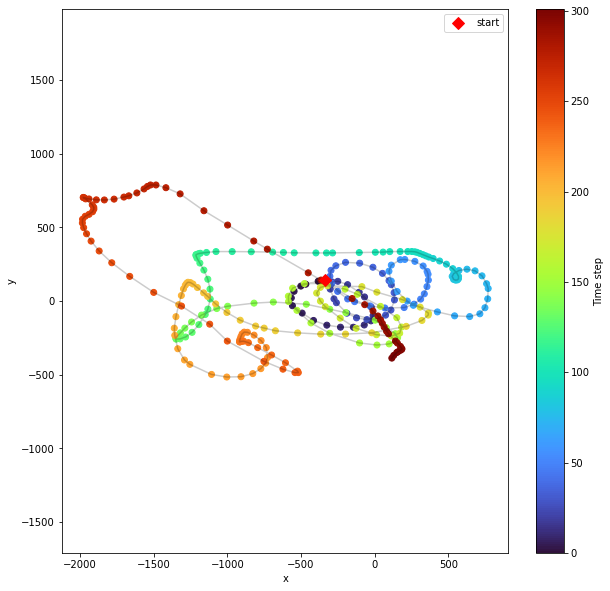

In [343]:
trialno = 13
nTime = 60
df = utils.LoadData.mouseMovement(subj, task, trialno)
x = utils.DataProcessing.rollingWindow_from_df(df, nTime, 1)

d_trial = df[["x-shift", "y-shift"]].values
d_trial_cum = d_trial.cumsum(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.Plot.traj_withColour(d_trial_cum[:, 0], d_trial_cum[:, 1], fig, ax)

In [344]:
y = model(torch.from_numpy(x).double())
h = model.model.x_hidden.detach().cpu().numpy()



# Distance between neighborhoods

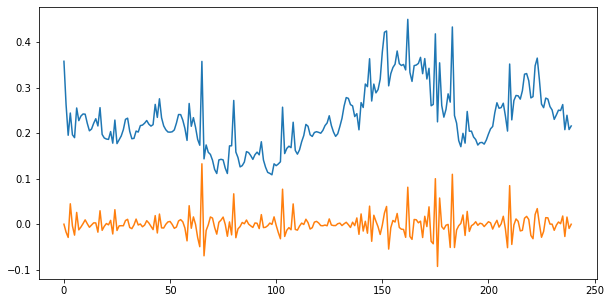

In [354]:
# measure = 'manhattan'
measure = 'euclidean'
# measure = 'cosine'
# measure = 'correlation'
h_ = h
# h_ = StandardScaler().fit_transform(h_)
h_ = scale(h_, axis=0)
dist = distance.pdist(h, measure)
# dist = distance.pdist(h_, 'minkowski', p=4)
dist = distance.squareform(dist)
dist = np.diagonal(dist, offset=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# dist.shape
ax.plot(dist)
# Y = distance.squareform(Y)

# apply filter
b, a = scipy.signal.butter(5, 10, 'highpass', fs=60)
dist = scipy.signal.filtfilt(b, a, dist)
ax.plot(dist)


In [334]:
measure = 'euclidean'
h_ = h
# h_ = scale(h_, axis=0)
dist = distance.pdist(h, measure)
dist = distance.squareform(dist)
dist_sort = np.argsort(dist, axis=0)
# dist_sort[:, 9]

/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


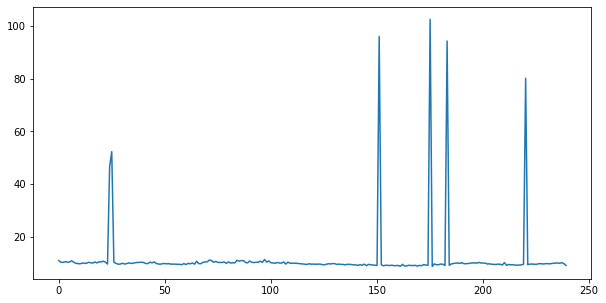

In [351]:
h_ = TSNE(n_components=3, learning_rate='auto', init='pca').fit_transform(h)
dist = distance.pdist(h_, measure)
dist = distance.squareform(dist)
dist = np.diagonal(dist, offset=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(dist)


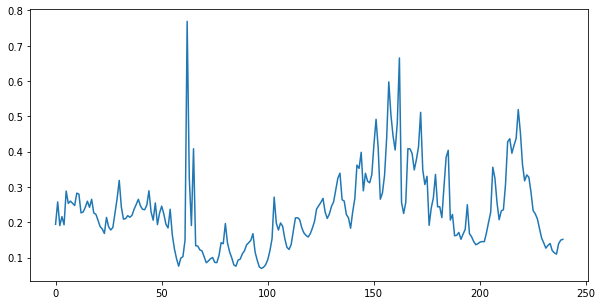

In [349]:
h_ = MDS(n_components=3, max_iter=2000, eps=1e-5).fit_transform(h)
dist = distance.pdist(h_, measure)
dist = distance.squareform(dist)
dist = np.diagonal(dist, offset=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(dist)

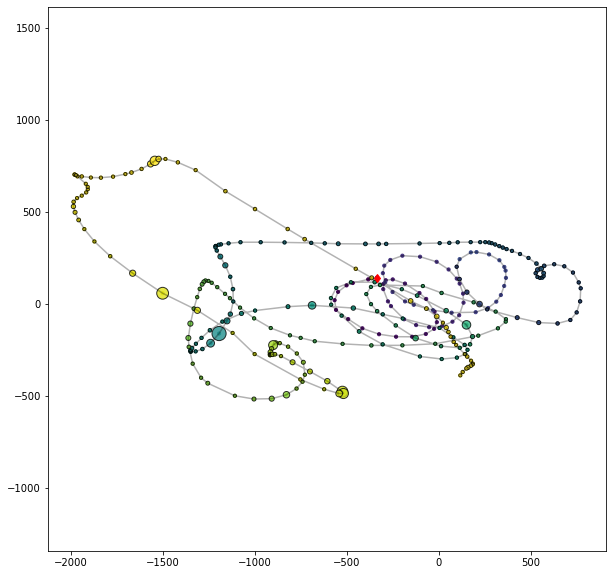

In [380]:
def traj_withWeight(x, y, w, align='e', ax=None, seqColormap='viridis', minSize=10):
    ''' Plot trajectory with weights
    align: 'e'(default) end, 's' start, 'c' center
    '''
    from sklearn.preprocessing import minmax_scale
    w = minmax_scale(w, feature_range=(minSize, 200)) 
    
    n = len(x)
    nW = len(w)
    if align == 's':
        offset = 0
    elif align == 'e':
        offset = n - nW
    elif align == 'c':
        offset = (n - nW)//2
    else:
        raise ValueError('align must be e, s, or c')
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
    # plot line
    ax.plot(x, y, 'k', alpha=0.3)
    
    # plot sample points with color
    cmap = mpl.cm.get_cmap(seqColormap)
    colors = cmap(range(n))    
    ax.scatter(x, y, c=colors, s=minSize)
    
    # plot starting point
    ax.plot(x[0], y[0], 'dr')
    
    # plot weights
    ax.scatter(x[offset:offset+nW], y[offset:offset+nW], 
               c=colors[offset:offset+nW, :],
               s=w,
               edgecolors='k',
               alpha=0.8)
    ax.axis('equal')
    if ax is None:
        return fig, ax 
    
traj_withWeight(d_trial_cum[:, 0], d_trial_cum[:, 1], dist**2, align='e')


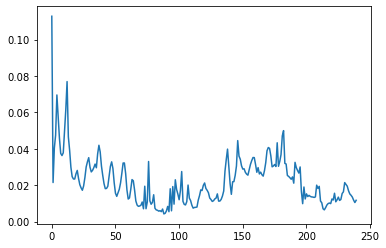

In [62]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=0.9)
h_ = pca.fit_transform(h)
# n = len(pca.explained_variance_ratio_)
# plt.bar(range(n), pca.explained_variance_ratio_.cumsum())
dist = utils.DataProcessing.diff(h_, measure='cosine')
plt.plot(dist)


# Embedding 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

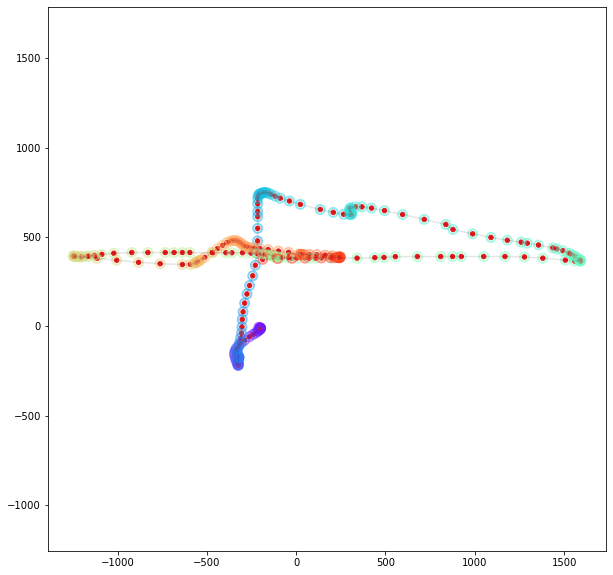

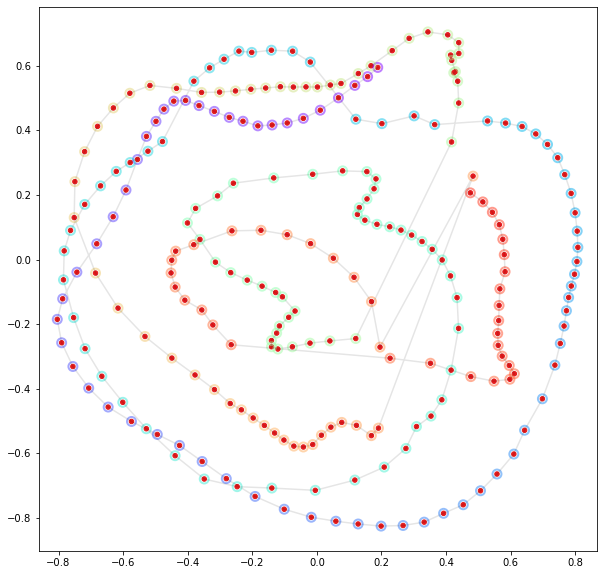

In [283]:
# use numpy to generate 10 data points in 4 clusters
# d = StandardScaler().fit_transform(d_trial_cum)
# clustering = DBSCAN(eps=0.2, min_samples=2).fit(d)





# nTime = h.shape[0]
# d_trial = df[["x-shift", "y-shift"]].values
# d_trial_cum = d_trial.cumsum(axis=0)
# x = d_flat


def clustering_embedding(x, embedding=True):
    from sklearn.cluster import OPTICS, SpectralClustering
    from sklearn.mixture import GaussianMixture
    from sklearn.manifold import MDS


    # x = StandardScaler().fit_transform(x)
    labels = DBSCAN(eps=0.6, min_samples=4, metric='euclidean').fit_predict(x)
    # labels = OPTICS(min_samples=5, metric='minkowski').fit_predict(x)
    # labels = GaussianMixture(n_components=4, random_state=0).fit_predict(x)

    # labels = SpectralClustering(n_clusters=4,
    #                             assign_labels='discretize',
    #                             random_state=0).fit_predict(x)
    if embedding:
        # x = TSNE(n_components=2, learning_rate='auto',
        #          init='pca').fit_transform(x)
        
        x = MDS(n_components=2).fit_transform(x)        
        return labels, x
    else:
        return labels


labels, x_embedded = clustering_embedding(h, embedding=True)
y = d_trial_cum[15:nTime+15, :]
plot_clusters(y[:, 0], y[:, 1], labels)
y = x_embedded
plot_clusters(y[:, 0], y[:, 1], labels)
labels


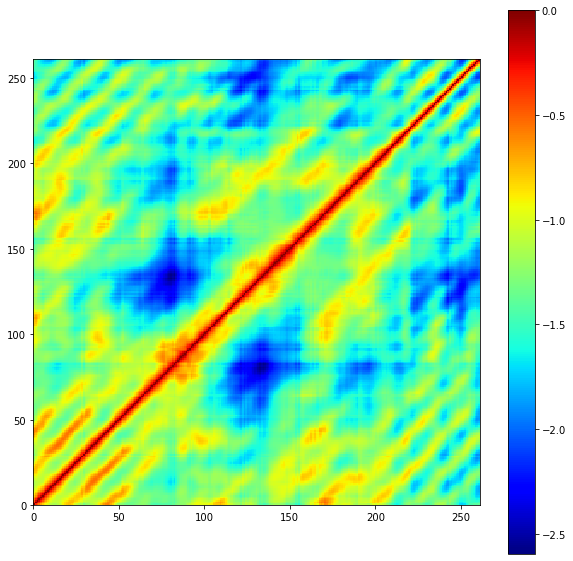

In [18]:
from scipy.spatial import distance
# measure = 'cityblock'
measure = 'euclidean'
# measure = 'correlation'
Y = distance.pdist(h, measure)
Y = distance.squareform(Y)
Y = -Y
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(Y, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')

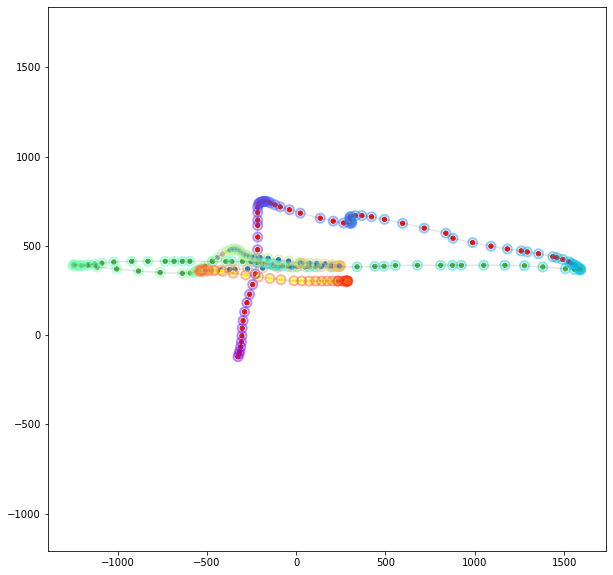

In [286]:
from sklearn.cluster import AgglomerativeClustering
c = np.diagflat(np.ones(len(h)-1), 1)

clustering = AgglomerativeClustering(n_clusters=20, connectivity=c, linkage='single').fit(h)

plot_clusters(X[nTime:nTime+len(h)], Y[nTime:nTime+len(h)], clustering.labels_)

# ax.scatter(X[nTime:nTime+nDist], Y[nTime:nTime+nDist], s=dist_)


<BarContainer object of 16 artists>

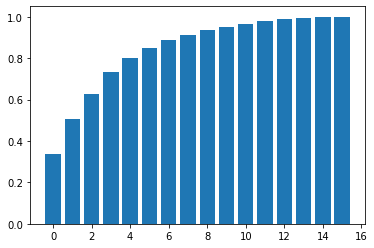

In [19]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit_transform(h)
n = len(pca.explained_variance_ratio_)
plt.bar(range(n), pca.explained_variance_ratio_.cumsum())